In [1]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline

ticker= "googl"
stock_data = yf.download(ticker, start="2016-01-04", end="2022-10-26")

[*********************100%***********************]  1 of 1 completed


In [2]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000


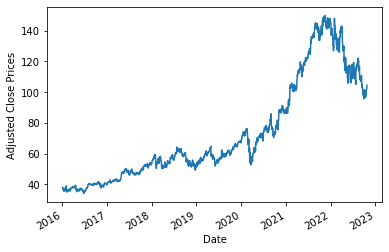

In [3]:
stock_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

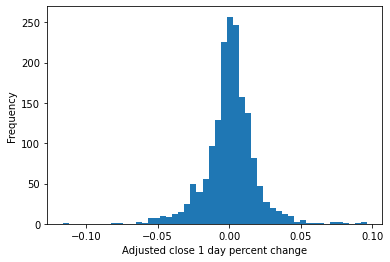

In [4]:
stock_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

In [5]:
feature_names = []
for n in [14, 30, 50, 200]:
    stock_data['ma' + str(n)] = talib.SMA(stock_data['Adj Close'].values, timeperiod=n)
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Adj Close'].values, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [6]:
stock_data['Volume_1d_change'] = stock_data['Volume'].pct_change()

volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)

In [7]:
stock_data['5d_future_close'] = stock_data['Adj Close'].shift(-5)
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5)

In [8]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Volume_1d_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2016-01-04,38.110001,38.110001,37.376999,37.972000,37.972000,67382000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.653500,NaN
2016-01-05,38.205002,38.459999,37.782501,38.076500,38.076500,45216000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.328960,37.266998,NaN
2016-01-06,37.518501,38.286499,37.400002,37.966499,37.966499,48206000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066127,35.978500,NaN
2016-01-07,37.324501,37.765499,36.764000,37.049999,37.049999,63132000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.309630,36.569500,NaN
2016-01-08,37.389999,37.506001,36.445999,36.545502,36.545502,47506000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.247513,35.524502,NaN


In [9]:
stock_data.dropna(inplace=True)

X = stock_data[feature_names]
y = stock_data['5d_close_future_pct']

train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [10]:
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

-0.5318394920334804 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


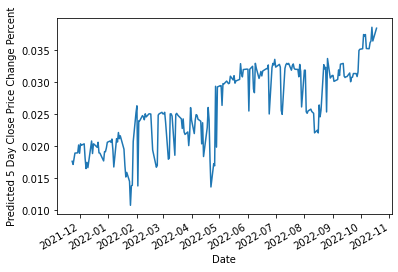

In [11]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()

In [12]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.046473180517960094
Mean Squared Error: 0.003156015551616565
Root Mean Squared Error: 0.056178426033634696


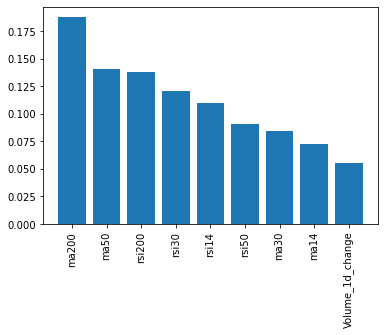

In [13]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()